<a href="http://www.utt.fr"><img src="logo-UTT.svg" width="200" align="left"></a>
### Formation d'Ingénieur en Génie Mécanique
#### Eléments de bureau d'études (code UE TN12 niveau L3)
---

* Rapide tutoriel sur les [notebook et JupyterLab](https://github.com/PasLafon/UTT-Teaching/blob/master/Tuto-Perso-Jupyter/Tuto-Jupyter.md)
* Rapide tutoriel pour [télécharger ce notebook](https://github.com/PasLafon/UTT-Teaching/blob/master/Tuto-Perso-Jupyter/Tuto-nbviewer-GitHub.md) et le rendre actif (l'éxecuter, le modifier, ..) 

---

# Vitesse maximale d'une voiture ...

---
Objectif de l'exercice :
* Mettre en équation un problème de mécanique simple, pour obtenir ici une équation différentielle.
* Apprendre à résoudre cette équation différentielle avec des méthodes numériques existantes, en s'initiant au langage python dans l'environnemen de NoteBook Juypter.
* Développer un regard critique sur les résultats obtenus.

---

### 1) Mise en équation :


On se donne le cahier des charges suivant :

* $M$ : masse totale du véhicule.
* $J_R$ : inertie des roues.
* $J_M$ : inertie du moteur.
* $r$  : rayon des roues.
* $p$ : pente de la route (%).
* $f$ : coeff de frottement sec global.
* $k$ : coeff de trainée aérodynamique.
* $i$ : rapport de réduction de la transmission (donc <1 !!).

Energie cinétique de la voiture (y compris parties tournantes) :

$$E_c = \frac{1}{2}MV^2 + 4\times\frac{1}{2}J_R\dot{\theta_R}^2 + \frac{1}{2}J_R\dot{\theta_M}^2$$

Avec :
* $\dot{\theta_R}$ : vitesse de rotation des roues.
* $\dot{\theta_M}=\dfrac{\dot{\theta_R}}{i}$ : vitesse de rotation du moteur
* $V=r\dot{\theta_R}$ : vitesse de la voiture.

Théorème de l'énergie cinétique :

$$\frac{\mathrm{d}E_C}{\mathrm{d}t} = \mathcal{P}_\text{Eff. extérieurs} + \mathcal{P}_\text{Eff. intérieurs} $$ 

$$\frac{\mathrm{d}E_C}{\mathrm{d}t} = \ddot{\theta_R} \dot{\theta_R} \left( Mr^2 + 4J_R+\frac{J_M}{i^2} \right)$$

Puissance des efforts intérieurs (>0)
* puissance du moteur : $\mathcal{P}_M=C_M\dot{\theta}_M$, vec $C_M$, le couple moteur.

$$\mathcal{P}_\text{Eff. intérieurs} = C_M\dot{\theta_M} =  \frac{C_M}{i}\dot{\theta_R}$$


Puissance des efforts extérieurs (<0) :

* Poids de la voiture sur la pente : $Mg\sin(\alpha)\simeq Mg\alpha\simeq Mgp$, si $\alpha$ est petit donc la pente en p% est faible, puissance correspondante : $MgpV$.
* frottement sec (pneu/route + transmission), fonction du poids de la voiture  : $Mgf$, puissance correspondante : $MgpV$.
* Trainée aérodynamique, effort de la forme : $kV^2$ avec $k=\frac{1}{2}\rho S C_x$, puissance correspondante : $kV^3$.

$$\mathcal{P}_\text{Eff. extérieurs}  = -MgpV - MgfV - kV^3 = -Mg(p+f)r\dot{\theta_R} - kr\dot{\theta_R}^3$$

D'où l'équation du mouvement de la voiture en fonction de $\theta_R$ :

$$\ddot{\theta_R} \dot{\theta_R} \left( Mr^2 + 4J_R+\frac{J_M}{i^2} \right) = -- kr\dot{\theta_R}^3  + \dot{\theta_R}\left( \frac{C_M}{i} -Mg(p+f)r\right)$$

Soit :

$$\ddot{\theta_R}\left( Mr^2 + 4J_R+\frac{J_M}{i^2} \right) = -- kr\dot{\theta_R}^2  + \left( \frac{C_M}{i} -Mg(p+f)r\right)$$


ou en fonction de $x(t)=r\theta_R(t)$ la position de la voiture :

$$\ddot{x}(t)\left( Mr^3 + 4J_Rr+\frac{J_Mr}{i^2} \right) = - kr\dot{x}(t)^2 +  \left( \frac{r^2C_M}{i} -Mg(p+f)r^3\right)$$

On obtient une équation différentielle du **2nd ordre** (terme en $\ddot{x}(t)$) et **non linéaire** (terme $\dot{x}(t)^2$) qui ne peut être résolue que **numériquement**, mais que l'on peut écrire comme une équation du **1er ordre non linéaire** avec $\dot{x}(x)=V(t)$ et $\ddot{x}(x)=\dot{V}(t)$ (toujours impossible à resoudre analytiquement) :

$$\dot{V}(t)\left( Mr^3 + 4J_Rr+\frac{J_Mr}{i^2} \right) = - krV{x}(t)^2 +  \left( \frac{r^2C_M}{i} -Mg(p+f)r^3\right)$$

C'est comme cela que l'on va la résoudre numériquement ....

### 1ère simulation :

Couple moteur constant ....simple mais pas très réaliste ....

Vitesse maxi : 173.41km/h
Vitesse de rotation du moteur correspondante : 11560.45tr/min


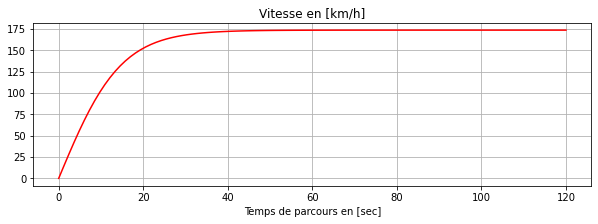

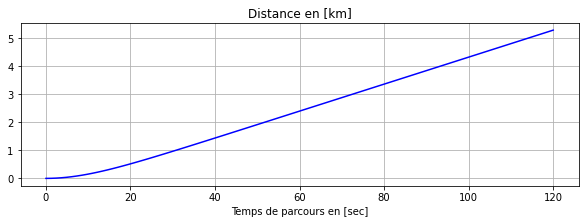

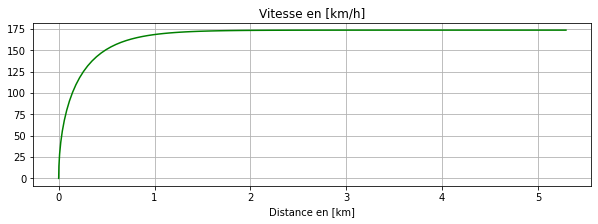

In [1]:
# import des librairies nécessaires :
# Pour définir et calculer avec des vecteurs et des matrices : 
import numpy as np
# Pour résoudre des équations, dériver, intégrer numériquement, optimiser etc ...
from scipy.integrate import odeint
# Pour le tracé de graphiques:
import matplotlib.pyplot as plt


# Constant globale : masse volumique de l'air et gravité
rho = 1.225
g   = 9.81
# Pente de la route en (%)
p = 0.05

# Caractéristique de la voiture :
Mvoit = 1800      # Masse en [kg]
Rroue = 0.3       # Rayon en [m]
Cx = 0.2          # Coefficient de trainée aérodynamique.
Sfront = 2.5      # Surface frontale en [m2]
k = 0.5*Cx*Sfront # Coeff de trainée pour calculer les forces dues à la trainée aérodynamique
f = 0.012         # Coeff de frottement pneu/route.

# Couple Moteur en N.M
CMot = 300

# Estimation du rapport global de la transmission : 120km/h, à 8000 tr/min pour le moteur électrique.
irap = (120/3.6)/(Rroue*8000*np.pi/30)

# Inertie du moteur -> celle d'un cylindre de masse vol. 4000 kg/m3 de rayon 10cm et de longueur 30cm
JMot = 0.5*(np.pi*0.1**2*0.3*4000)*0.1**2 
# Inertie d'une roue 17p masse 20kg, rayon 30cm.
JR = 0.5*20*Rroue**2                        

# Fonction pour calculer les constantes du modèle :
def coef_model1():    
    Kinertie = Mvoit*Rroue**3 + 4*JR*Rroue + (JMot*Rroue)/irap**2
    Kmot = Rroue**2*CMot/irap - Mvoit*g*(p + f)*Rroue**3
    Kfvis = k*Rroue
    return Kinertie,Kmot,Kfvis

# Fonction définissant l'équation à résoudre.
# x[0] -> la position [m]
# x[1] -> la vitesse [m/s]
# t la variable.
def voiture(x,t):
    
    dx = x[1]
    
    Kinertie,Kmot,Kfvis = iter(coef_model1())
    # Retour de l'équation, forme imposée par la méthode odeint :
    eq = [[],[]]
    # la vitesse fournie en entrée (derivée 1ère)
    eq[0] = x[1]
    # l'accélération calculée (derivée 2nd)
    eq[1] = - (Kfvis/Kinertie)*dx**2 + Kmot/Kinertie
    
    return eq

# On génére un vecteur de temps de simulation : 0 à 120s, 100 valeurs.
time =  np.linspace(0,120,100)
loi1 = odeint(voiture,[0,0],time)

Vmax = np.nanmax(loi1[:,1])
print('Vitesse maxi : %.2fkm/h'%(Vmax*3.6))
print('Vitesse de rotation du moteur correspondante : %.2ftr/min'%(Vmax/(Rroue*irap*np.pi/30)))
# Tracé de la vitesse en fonction du temps :
plt.figure(figsize=(10,3))
plt.xlabel('Temps de parcours en [sec]')
plt.title('Vitesse en [km/h]')
plt.grid('on')
plt.plot(time,loi1[:,1]*3.6,'r')

# Tracé de la distance en fonction du temps :
plt.figure(figsize=(10,3))
plt.xlabel('Temps de parcours en [sec]')
plt.title('Distance en [km]')
plt.grid('on')
plt.plot(time,loi1[:,0]*1e-3,'b')

# Tracé de la vitesse en fonction de la distance :
plt.figure(figsize=(10,3))
plt.xlabel('Distance en [km]')
plt.title('Vitesse en [km/h]')
plt.grid('on')
plt.plot(loi1[:,0]*1e-3,loi1[:,1]*3.6,'g')


### 2ième simulation ...

Avec une loi de couple plus réaliste, par exemple celle du moteur à induction qui équipe la Tesla Model 3 (source : https://www.guillaumedarding.fr/presentation-moteur-tesla-model-3-8025367.html)

Dans le modèle cela va se traduire par une fonction donnant le couple moteur $C_M$ en fonction de $\dot{\theta}_M$, sa vitesse de rotation. On aura alors en fonction du rapport de la transmission $i$ et de la vitesse de rotation des roues $\dot{\theta}_R$ ou de la vitesse de la voiture $V$ et du rayon des roues $r$ :

$$C_M=f(\dot{\theta}_M)=f\left(\frac{\dot{\theta}_R}{i}\right)=f\left(\frac{V}{ri}\right)$$

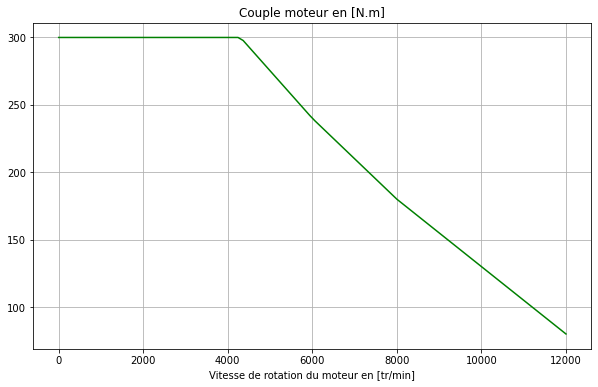

In [2]:
#
# On défini une fonction qui renvoie le couple moteur en fonction de la vitesse
# de rotation du moteur. On utilise la méthode np.interp qui permet de définir
# une fonction par interpolation  linéaire docs cf : https://numpy.org/doc/stable/
#
def loi_moteur(N):
    Couple = np.array([300,300,240,180,80])  # Valeur des couples en N.m 
    VitRot = np.array([0,4300,6000,8000,12000]) # Valeur des vitesses de rotation correspondante en tr/min
    
    CMot = np.interp(N,VitRot,Couple)
    return CMot

# Tracé de la loi de couple :
Nmot = np.linspace(0,12000,100)
plt.figure(figsize=(10,6))
plt.plot(Nmot,loi_moteur(Nmot),'g-')
plt.xlabel('Vitesse de rotation du moteur en [tr/min]')
plt.title('Couple moteur en [N.m]')
plt.grid('on')

Vitesse maxi : 123.64km/h
Vitesse de rotation du moteur correspondante : 8242.75tr/min


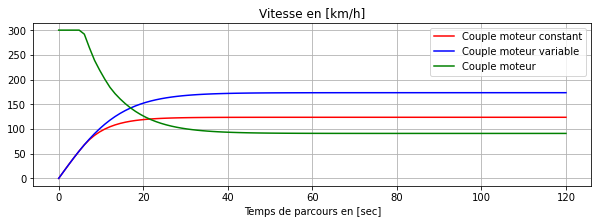

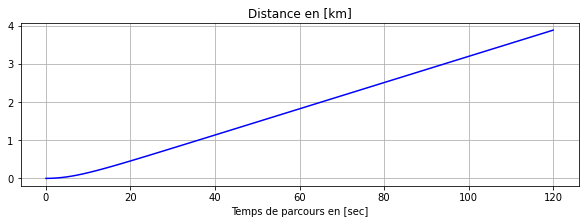

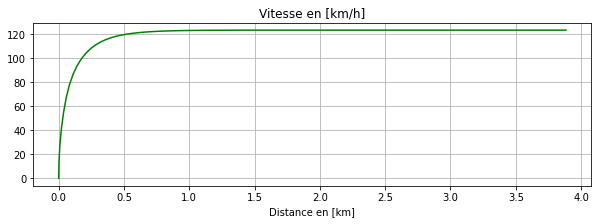

In [5]:
# Prise en compte de la loi de couple moteur dans les coefficients.

def coef_model2(V):
    # Le couple moteur est calculé à partir de la vitesse de la voiture (V en [m/s]), qui est variable
    # et du rapport de réduction de la transmission et du rayon de roue (fixe)
    Nmot = V/(Rroue*irap*np.pi/30)
    CMot = loi_moteur(Nmot)
    Kinertie = Mvoit*Rroue**3 + 4*JR*Rroue + (JMot*Rroue)/irap**2
    Kmot = Rroue**2*CMot/irap - Mvoit*g*(p + f)*Rroue**3
    Kfvis = k*Rroue
    return Kinertie,Kmot,Kfvis


def voiture(x,t):
    
    dx = x[1] # dx -> vitesse de la voiture en [m/s]

    Kinertie,Kmot,Kfvis = iter(coef_model2(dx))
        
    eq = [[],[]]
    eq[0] = x[1]
    eq[1] = - (Kfvis/Kinertie)*dx**2 + Kmot/Kinertie
    
    return eq

time =  np.linspace(0,120,100)
loi2 = odeint(voiture,[0,0],time)

Vmax = np.nanmax(loi2[:,1])
print('Vitesse maxi : %.2fkm/h'%(Vmax*3.6))
print('Vitesse de rotation du moteur correspondante : %.2ftr/min'%(Vmax/(Rroue*irap*np.pi/30)))
# Tracé de la vitesse en fonction du temps :
plt.figure(figsize=(10,3))
plt.xlabel('Temps de parcours en [sec]')
plt.title('Vitesse en [km/h]')
plt.grid('on')
plt.plot(time,loi2[:,1]*3.6,'r')
plt.plot(time,loi1[:,1]*3.6,'b')
Nmot=loi1[:,1]/(Rroue*irap*np.pi/30)
plt.plot(time,loi_moteur(Nmot),'g')
plt.legend(('Couple moteur constant','Couple moteur variable','Couple moteur'))

# Tracé de la distance en fonction du temps :
plt.figure(figsize=(10,3))
plt.xlabel('Temps de parcours en [sec]')
plt.title('Distance en [km]')
plt.grid('on')
plt.plot(time,loi2[:,0]*1e-3,'b')

# Tracé de la vitesse en fonction de la distance :
plt.figure(figsize=(10,3))
plt.xlabel('Distance en [km]')
plt.title('Vitesse en [km/h]')
plt.grid('on')
plt.plot(loi2[:,0]*1e-3,loi2[:,1]*3.6,'g')

### 3ième simulation ...

Allons un peu plus loin en intégrant dans le modèle une boite vitesse ...

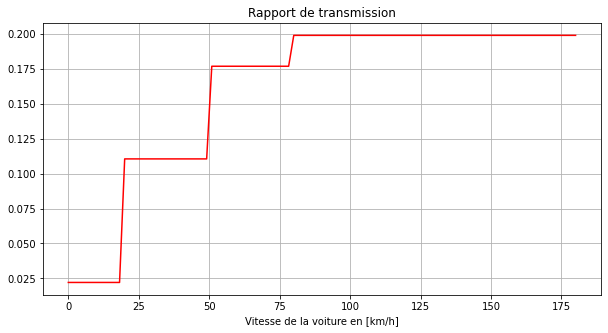

In [118]:
def loi_rapport(V):
    coef = 30/(3.6*Rroue*np.pi)
    # Rapport de transmission  ratio vitesse de la voiture en km/h et vitesse de moteur en tr/min
    r1 = coef*10/4000
    r2 = coef*50/4000
    r3 = coef*80/4000
    r4 = coef*180/8000
    Vitesse  = np.array([0,20,  20,50, 50,80, 80,180]) # km/h
    RapBoite = np.array([r1,r1, r2,r2, r3,r3, r4,r4])
    rapport =  np.interp(V*3.6,Vitesse,RapBoite,left=np.NaN,right=np.NaN)
    return rapport

plt.figure(figsize=(10,5))
V = np.linspace(0,180,100)
plt.plot(V,loi_rapport(V/3.6),'r')
plt.xlabel('Vitesse de la voiture en [km/h]')
plt.title('Rapport de transmission')
plt.grid('on')

Vitesse maxi : 122.99km/h
Vitesse de rotation du moteur correspondante : 8199.29tr/min


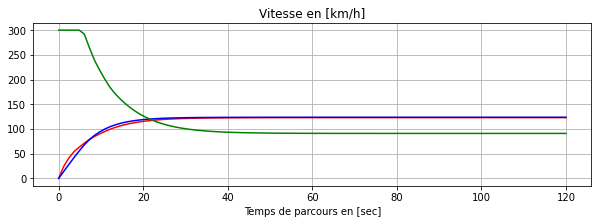

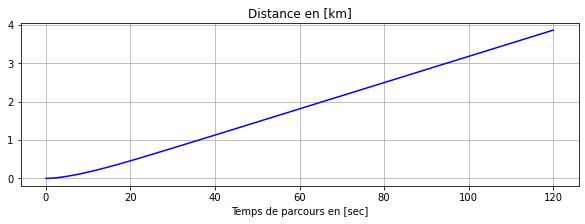

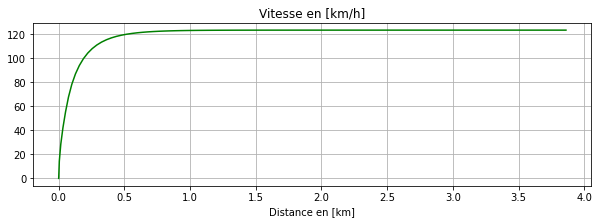

In [119]:

# Prise en compte de la loi de couple moteur et du rapport de transmission dans les coefficients.

def coef_model3(V):
    # Le couple moteur est calculé à partir de la vitesse de la voiture (V en [m/s]), qui est variable
    # et du rapport de réduction de la transmission et du rayon de roue (fixe)
    irap = loi_rapport(V)
    Nmot = V/(Rroue*irap*np.pi/30)
    CMot = loi_moteur(Nmot)
    Kinertie = Mvoit*Rroue**3 + 4*JR*Rroue + (JMot*Rroue)/irap**2
    Kmot = Rroue**2*CMot/irap - Mvoit*g*(p + f)*Rroue**3
    Kfvis = k*Rroue
    return Kinertie,Kmot,Kfvis


def voiture(x,t):
    
    dx = x[1] # dx -> vitesse de la voiture en [m/s]

    Kinertie,Kmot,Kfvis = iter(coef_model3(dx))
        
    eq = [[],[]]
    eq[0] = x[1]
    eq[1] = - (Kfvis/Kinertie)*dx**2 + Kmot/Kinertie
    
    return eq

time =  np.linspace(0,120,100)
loi3 = odeint(voiture,[0,0],time)

Vmax = np.nanmax(loi3[:,1])
print('Vitesse maxi : %.2fkm/h'%(Vmax*3.6))
print('Vitesse de rotation du moteur correspondante : %.2ftr/min'%(Vmax/(Rroue*irap*np.pi/30)))

# Tracé de la vitesse en fonction du temps :
plt.figure(figsize=(10,3))
plt.xlabel('Temps de parcours en [sec]')
plt.title('Vitesse en [km/h]')
plt.grid('on')
plt.plot(time,loi3[:,1]*3.6,'r')
plt.plot(time,loi2[:,1]*3.6,'b')
#plt.plot(time,loi1[:,1]*3.6,'k')
Nmot=loi1[:,1]/(Rroue*irap*np.pi/30)
plt.plot(time,loi_moteur(Nmot),'g')

# Tracé de la distance en fonction du temps :
plt.figure(figsize=(10,3))
plt.xlabel('Temps de parcours en [sec]')
plt.title('Distance en [km]')
plt.grid('on')
plt.plot(time,loi3[:,0]*1e-3,'b')

# Tracé de la vitesse en fonction de la distance :
plt.figure(figsize=(10,3))
plt.xlabel('Distance en [km]')
plt.title('Vitesse en [km/h]')
plt.grid('on')
plt.plot(loi3[:,0]*1e-3,loi2[:,1]*3.6,'g')